## **Tugas Besar Pemrosesan Citra Digital**

**Klasifikasi Pneumonia dan Tuberculosis Menggunakan DenseNet-121
berdasarkan Citra X-Ray**
  
Achmad Fahriza - 1301213006  
Kemal Crisannaufal - 1301213133  
Pravitya Lintang Insani - 1301213204

In [1]:
#Import Modul
import os
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import imagehash
import seaborn as sns

In [2]:
#Fungsi untuk Contrast Stretching
def contrast_stretching(img):
  in_min = np.percentile(img, 5)
  in_max = np.percentile(img, 95)
  out_min, out_max = img.min(), img.max()
  img_contrast = (img - in_min) * ((out_max - out_min) / (in_max - in_min)) + out_min
  img_contrast = np.clip(img_contrast, out_min, out_max)
  return img_contrast

In [3]:
#Fungsi untuk Median Filtering
def median_filtering(img):
    img = cv2.medianBlur(img, 3)
    return img

In [4]:
#Fungsi untuk Load Data
#Resize, normalisasi, median filtering, contrast stretching
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = img_array.astype('float32') / 255.0
    img_array = median_filtering(img_array)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    img_array = contrast_stretching(img_array)
    return img_array

#### **Load Data**  

Data di-load dan digabungkan antara data Tuberculosis dengan data Pneumonia dan paru-paru normal. Pada data Pneuomina dan normal data telah dibagi menjadi data train, data validation, dan data test, sedangkan pada data Tuberculosis data hanya terdiri dari sebuah folder berisi citra x-ray tuberculosis (tanpa pemisahan data). Oleh karena itu data Tuberculosis dilakukan pemisahan data di awal untuk digabungkan dengan data Pneumonia dan Normal.

In [5]:
#Hash untuk cek duplikat
def load_and_hash_image(image_path):
    with Image.open(image_path) as img:
        return str(imagehash.average_hash(img))


#### **Load Data Tuberculosis**

In [6]:
train_dir = r'D:\PCD\Data'

categories = ['Tuberculosis']

data = []
labels = []
hashes = {}
duplicates = []

for category in categories:
    path = os.path.join(train_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_hash = load_and_hash_image(img_path)

        if img_hash in hashes:
            duplicates.append((img_path, hashes[img_hash]))
            print("Duplikat:", img_path, "-", hashes[img_hash])
        else:
            hashes[img_hash] = img_path
            image = load_image(img_path)
            data.append(image)
            labels.append(category)

Duplikat: D:\PCD\Data\Tuberculosis\Tuberculosis-244.png - D:\PCD\Data\Tuberculosis\Tuberculosis-243.png
Duplikat: D:\PCD\Data\Tuberculosis\Tuberculosis-348.png - D:\PCD\Data\Tuberculosis\Tuberculosis-346.png
Duplikat: D:\PCD\Data\Tuberculosis\Tuberculosis-405.png - D:\PCD\Data\Tuberculosis\Tuberculosis-386.png
Duplikat: D:\PCD\Data\Tuberculosis\Tuberculosis-430.png - D:\PCD\Data\Tuberculosis\Tuberculosis-378.png
Duplikat: D:\PCD\Data\Tuberculosis\Tuberculosis-469.png - D:\PCD\Data\Tuberculosis\Tuberculosis-467.png
Duplikat: D:\PCD\Data\Tuberculosis\Tuberculosis-470.png - D:\PCD\Data\Tuberculosis\Tuberculosis-467.png
Duplikat: D:\PCD\Data\Tuberculosis\Tuberculosis-471.png - D:\PCD\Data\Tuberculosis\Tuberculosis-396.png
Duplikat: D:\PCD\Data\Tuberculosis\Tuberculosis-510.png - D:\PCD\Data\Tuberculosis\Tuberculosis-509.png
Duplikat: D:\PCD\Data\Tuberculosis\Tuberculosis-571.png - D:\PCD\Data\Tuberculosis\Tuberculosis-566.png
Duplikat: D:\PCD\Data\Tuberculosis\Tuberculosis-582.png - D:\PCD

In [7]:
#Split data menjadi data train, data validation, dan data test
data_train, data_val_test, labels_train, labels_val_test = train_test_split(data, labels, test_size=0.25, random_state=42)
data_val, data_test, labels_val, labels_test = train_test_split(data_val_test, labels_val_test, test_size=0.5, random_state=42)

#### **Load Data Pneumonia dan Normal**

In [8]:
#Load Data Train Normal dan Pneumonia
train_dir = r'D:\PCD\Data'

categories = ['Normal', 'Pneumonia']

data = []
labels = []

for category in categories:
    path = os.path.join(train_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_hash = load_and_hash_image(img_path)

        if img_hash in hashes:
            duplicates.append((img_path, hashes[img_hash]))
            print("Duplikat:", img_path, "-", hashes[img_hash])
        else:
            hashes[img_hash] = img_path
            image = load_image(img_path)
            data.append(image)
            labels.append(category)

#Gabungkan data train yang baru di load dengan data sebelumnya (data TBC)
data_train.extend(data)
labels_train.extend(labels)

Duplikat: D:\PCD\Data\Normal\IM-0300-0001.jpeg - D:\PCD\Data\Normal\IM-0187-0001.jpeg
Duplikat: D:\PCD\Data\Normal\IM-0320-0001.jpeg - D:\PCD\Data\Normal\IM-0160-0001.jpeg
Duplikat: D:\PCD\Data\Normal\IM-0329-0001.jpeg - D:\PCD\Data\Normal\IM-0298-0001.jpeg
Duplikat: D:\PCD\Data\Normal\IM-0332-0001.jpeg - D:\PCD\Data\Normal\IM-0327-0001.jpeg
Duplikat: D:\PCD\Data\Normal\IM-0388-0001.jpeg - D:\PCD\Data\Normal\IM-0276-0001.jpeg
Duplikat: D:\PCD\Data\Normal\IM-0438-0001.jpeg - D:\PCD\Data\Normal\IM-0276-0001.jpeg
Duplikat: D:\PCD\Data\Normal\IM-0467-0001-0002.jpeg - D:\PCD\Data\Normal\IM-0341-0001.jpeg
Duplikat: D:\PCD\Data\Normal\IM-0475-0001.jpeg - D:\PCD\Data\Normal\IM-0268-0001.jpeg
Duplikat: D:\PCD\Data\Normal\IM-0487-0001.jpeg - D:\PCD\Data\Normal\IM-0268-0001.jpeg
Duplikat: D:\PCD\Data\Normal\IM-0505-0001.jpeg - D:\PCD\Data\Normal\IM-0496-0001.jpeg
Duplikat: D:\PCD\Data\Normal\IM-0515-0001.jpeg - D:\PCD\Data\Normal\IM-0160-0001.jpeg
Duplikat: D:\PCD\Data\Normal\IM-0519-0001-0001.jp

In [9]:
#Load Data Validation
val_dir = r'D:\PCD\Data\val'

categories = ['Normal', 'Pneumonia']

data = []
labels = []

for category in categories:
    path = os.path.join(val_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_hash = load_and_hash_image(img_path)

        if img_hash in hashes:
            duplicates.append((img_path, hashes[img_hash]))
            print("Duplikat:", img_path, "-", hashes[img_hash])
        else:
            hashes[img_hash] = img_path
            image = load_image(img_path)
            data.append(image)
            labels.append(category)

#Gabungkan data validation yang baru di load dengan data validation sebelumnya (data TBC)
data_val.extend(data)
labels_val.extend(labels)

Duplikat: D:\PCD\Data\val\Normal\NORMAL2-IM-1056-0001.jpeg - D:\PCD\Data\Pneumonia\person465_virus_957.jpeg
Duplikat: D:\PCD\Data\val\Normal\NORMAL2-IM-1094-0001.jpeg - D:\PCD\Data\Normal\IM-0160-0001.jpeg
Duplikat: D:\PCD\Data\val\Normal\NORMAL2-IM-1102-0001.jpeg - D:\PCD\Data\Pneumonia\person37_bacteria_189.jpeg
Duplikat: D:\PCD\Data\val\Normal\NORMAL2-IM-1120-0001.jpeg - D:\PCD\Data\Normal\IM-0439-0001-0002.jpeg
Duplikat: D:\PCD\Data\val\Normal\NORMAL2-IM-1142-0001.jpeg - D:\PCD\Data\Normal\IM-0268-0001.jpeg
Duplikat: D:\PCD\Data\val\Normal\NORMAL2-IM-1148-0001.jpeg - D:\PCD\Data\Normal\NORMAL2-IM-0523-0001.jpeg
Duplikat: D:\PCD\Data\val\Normal\NORMAL2-IM-1150-0001.jpeg - D:\PCD\Data\val\Normal\NORMAL2-IM-1106-0001.jpeg
Duplikat: D:\PCD\Data\val\Normal\NORMAL2-IM-1152-0001-0001.jpeg - D:\PCD\Data\Normal\IM-0160-0001.jpeg
Duplikat: D:\PCD\Data\val\Normal\NORMAL2-IM-1169-0001.jpeg - D:\PCD\Data\Normal\IM-0268-0001.jpeg
Duplikat: D:\PCD\Data\val\Normal\NORMAL2-IM-1177-0001.jpeg - D:\PC

In [10]:
#Load Data Test Normal dan Pneumonia
test_dir = r'D:\PCD\Data\test'

categories = ['Normal', 'Pneumonia']

data = []
labels = []

for category in categories:
    path = os.path.join(test_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_hash = load_and_hash_image(img_path)

        if img_hash in hashes:
            duplicates.append((img_path, hashes[img_hash]))
            print("Duplikat:", img_path, "-", hashes[img_hash])
        else:
            hashes[img_hash] = img_path
            image = load_image(img_path)
            data.append(image)
            labels.append(category)

#Gabungkan data test yang baru di load dengan data test sebelumnya (data TBC)
data_test.extend(data)
labels_test.extend(labels)

Duplikat: D:\PCD\Data\test\Normal\IM-0059-0001.jpeg - D:\PCD\Data\val\Pneumonia\person1416_virus_2427.jpeg
Duplikat: D:\PCD\Data\test\Normal\IM-0061-0001.jpeg - D:\PCD\Data\Normal\IM-0593-0001.jpeg
Duplikat: D:\PCD\Data\test\Normal\IM-0083-0001.jpeg - D:\PCD\Data\Normal\IM-0566-0001.jpeg
Duplikat: D:\PCD\Data\test\Normal\IM-0093-0001.jpeg - D:\PCD\Data\Normal\NORMAL2-IM-1035-0001.jpeg
Duplikat: D:\PCD\Data\test\Normal\NORMAL2-IM-0013-0001.jpeg - D:\PCD\Data\Normal\NORMAL2-IM-0466-0001.jpeg
Duplikat: D:\PCD\Data\test\Normal\NORMAL2-IM-0072-0001.jpeg - D:\PCD\Data\Normal\IM-0439-0001-0001.jpeg
Duplikat: D:\PCD\Data\test\Normal\NORMAL2-IM-0092-0001.jpeg - D:\PCD\Data\val\Normal\NORMAL2-IM-1315-0001.jpeg
Duplikat: D:\PCD\Data\test\Normal\NORMAL2-IM-0096-0001.jpeg - D:\PCD\Data\test\Normal\NORMAL2-IM-0095-0001.jpeg
Duplikat: D:\PCD\Data\test\Normal\NORMAL2-IM-0112-0001.jpeg - D:\PCD\Data\test\Normal\IM-0070-0001.jpeg
Duplikat: D:\PCD\Data\test\Normal\NORMAL2-IM-0173-0001-0002.jpeg - D:\PCD\

#### **Data Train, Validation, dan Test Final**

In [11]:
#Ubah kelas menjadi numeric
numeric_label = {'Normal': 0, 'Pneumonia': 1, 'Tuberculosis': 2}

labels_train_numeric = np.array([numeric_label[label] for label in labels_train])
labels_val_numeric = np.array([numeric_label[label] for label in labels_val])
labels_test_numeric = np.array([numeric_label[label] for label in labels_test])

X_train = np.array(data_train)
X_val = np.array(data_val)
X_test = np.array(data_test)

#### **Data**

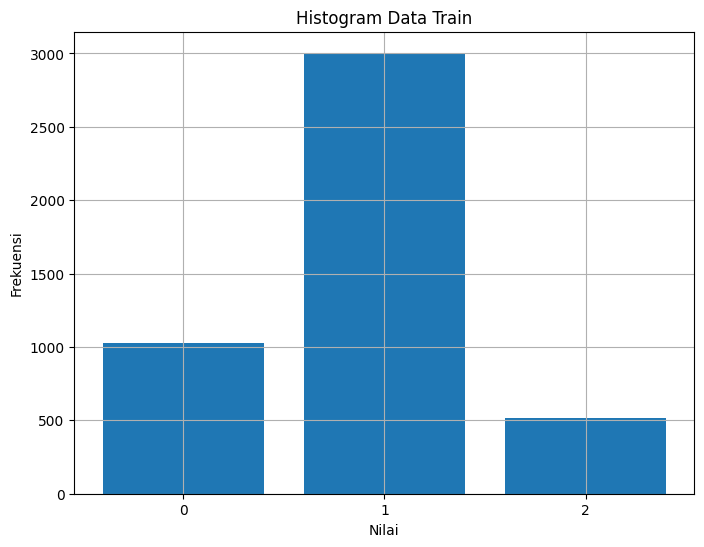

In [12]:
#Histogram Sebaran data Train
plt.figure(figsize=(8, 6))
plt.hist(labels_train_numeric, bins=np.arange(-0.5, 3, 1), align='mid', rwidth=0.8)

plt.title('Histogram Data Train')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')

plt.xticks(np.arange(0, 3, 1))
plt.grid(True)
plt.show()

Data train tidak seimbang dan didominasi oleh kelas Pneumonia. Oversampling SMOTE digunakan untuk menyeimbangkan kelas paru-paru normal dan tubercolis pada dataset.

In [13]:
#Penerapan SMOTE
smote = SMOTE()
X_train_oversampled, labels_oversampled = smote.fit_resample(X_train.reshape(len(X_train), 224*224*3), labels_train_numeric)
X_train_oversampled = X_train_oversampled.reshape(len(X_train_oversampled), 224, 224, 3)

c:\Users\pravi\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\pravi\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


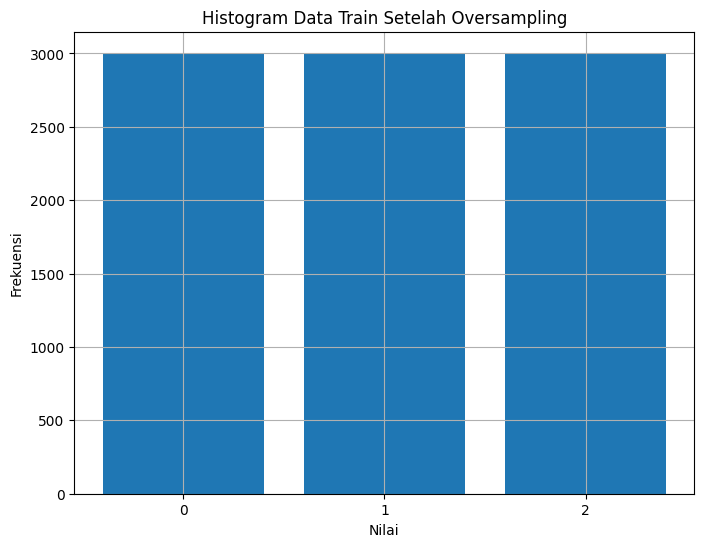

In [14]:
#Histogram data train setelah penerapan SMOTE
plt.figure(figsize=(8, 6))
plt.hist(labels_oversampled, bins=np.arange(-0.5, 3, 1), align='mid', rwidth=0.8)

plt.title('Histogram Data Train Setelah Oversampling')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')

plt.xticks(np.arange(0, 3, 1))
plt.grid(True)
plt.show()

In [15]:
#Jumlah data train setelah penerapan SMOTE
len(X_train_oversampled)

8994

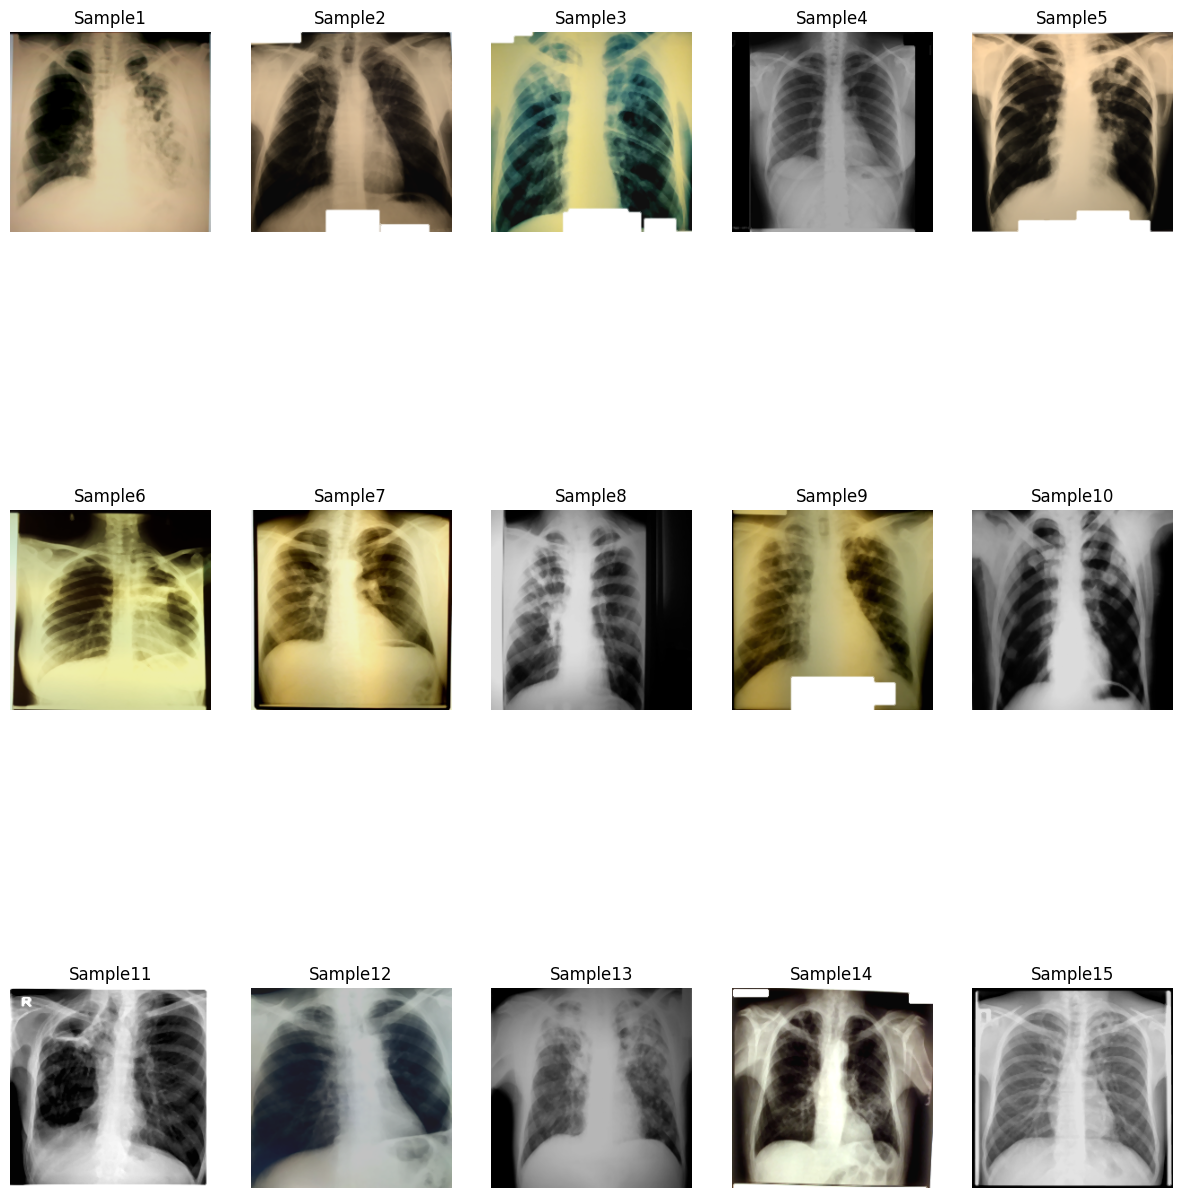

In [16]:
#Sample Hasil Dari Smote
plt.figure(figsize=(15, 30))
for i in range(15):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train_oversampled[i])
    plt.title("Sample" + str(i+1))
    plt.axis('off')
plt.show()

In [17]:
classes = ['Normal', 'Pneumonia', 'Tuberculosis']

####**Model**

In [22]:
#SKEMA 1
base_model = DenseNet121(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         )

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, labels_train_numeric, epochs=5, batch_size=32, validation_data=(X_val, labels_val_numeric))


Epoch 1/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.7711 - loss: 0.6604 - val_accuracy: 0.9470 - val_loss: 0.1393
Epoch 2/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.9020 - loss: 0.2462 - val_accuracy: 0.9615 - val_loss: 0.1184
Epoch 3/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.9147 - loss: 0.2183 - val_accuracy: 0.9595 - val_loss: 0.1183
Epoch 4/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.9202 - loss: 0.1912 - val_accuracy: 0.9672 - val_loss: 0.0936
Epoch 5/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9345 - loss: 0.1694 - val_accuracy: 0.9509 - val_loss: 0.1242


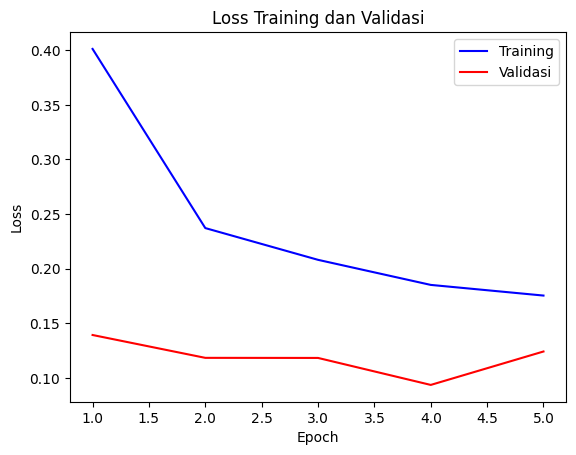

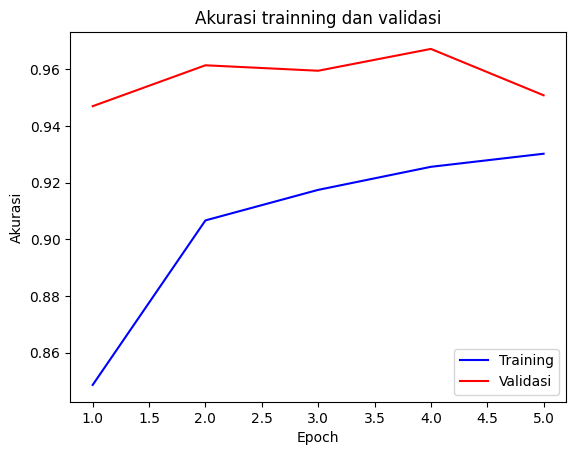

In [23]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Validasi')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_accuracy, 'b', label='Training')
plt.plot(epochs, val_accuracy, 'r', label='Validasi')
plt.title('Akurasi trainning dan validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

In [24]:
loss, accuracy = model.evaluate(X_test, labels_test_numeric)
print("Akurasi : ", accuracy * 100)

21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7198 - loss: 0.7133
Akurasi :  78.3410131931305


21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


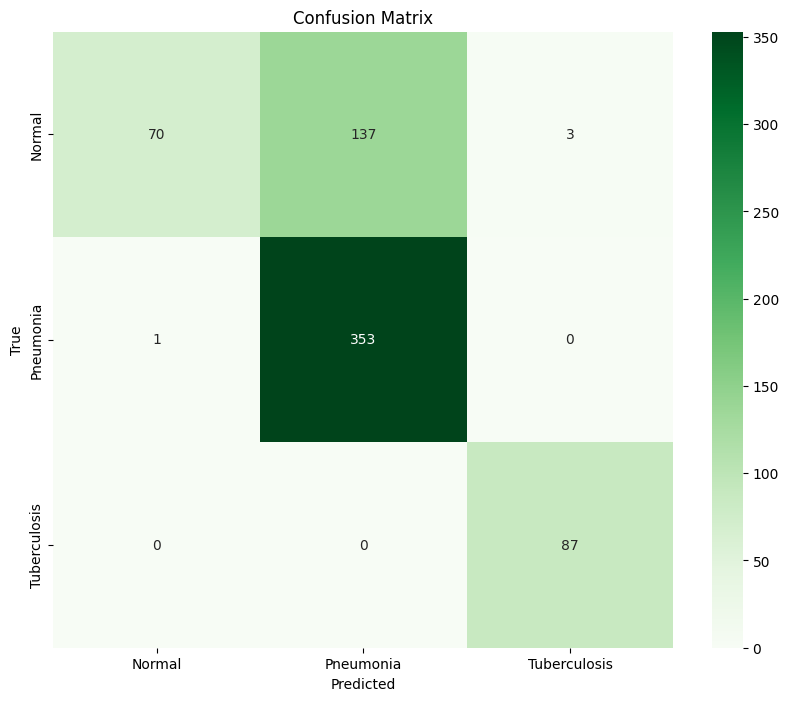

In [33]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(labels_test_numeric, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels= classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(labels_test_numeric, y_pred_classes))

21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step
              precision    recall  f1-score   support

           0       0.99      0.33      0.50       210
           1       0.72      1.00      0.84       354
           2       0.97      1.00      0.98        87

    accuracy                           0.78       651
   macro avg       0.89      0.78      0.77       651
weighted avg       0.84      0.78      0.75       651



In [ ]:
#SKEMA 2
base_model = DenseNet121(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         )

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_oversampled, labels_oversampled, epochs=5, batch_size=32, validation_data=(X_val, labels_val_numeric))


Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.8269 - loss: 0.4517 - val_accuracy: 0.9412 - val_loss: 0.1531
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.9445 - loss: 0.1431 - val_accuracy: 0.9499 - val_loss: 0.1356
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.9485 - loss: 0.1327 - val_accuracy: 0.9566 - val_loss: 0.1031
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.9598 - loss: 0.1052 - val_accuracy: 0.9393 - val_loss: 0.1620
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.9579 - loss: 0.1102 - val_accuracy: 0.9576 - val_loss: 0.0954


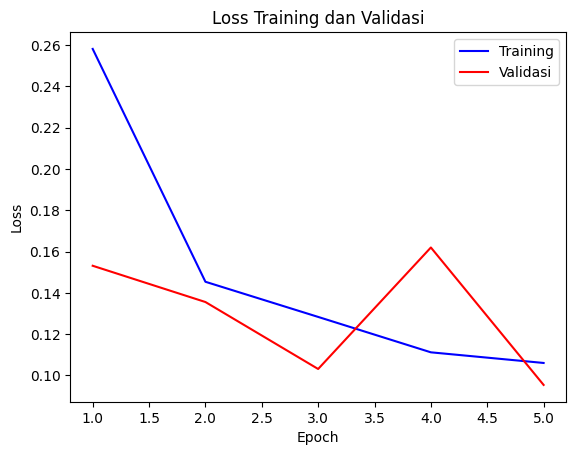

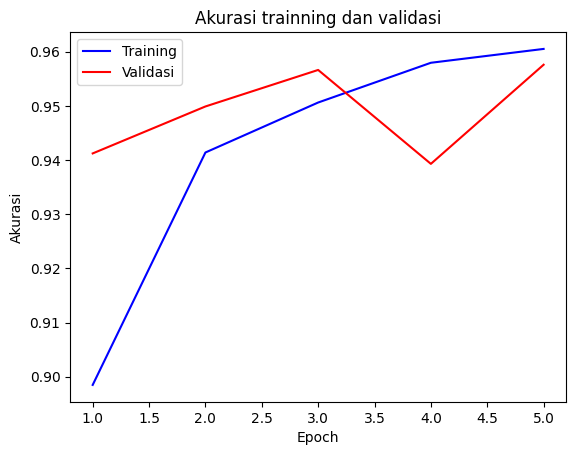

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Validasi')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_accuracy, 'b', label='Training')
plt.plot(epochs, val_accuracy, 'r', label='Validasi')
plt.title('Akurasi trainning dan validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

In [35]:
loss, accuracy = model.evaluate(X_test, labels_test_numeric)
print("Akurasi : ", accuracy * 100)

21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8121 - loss: 0.5246
Akurasi :  84.48540568351746


21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


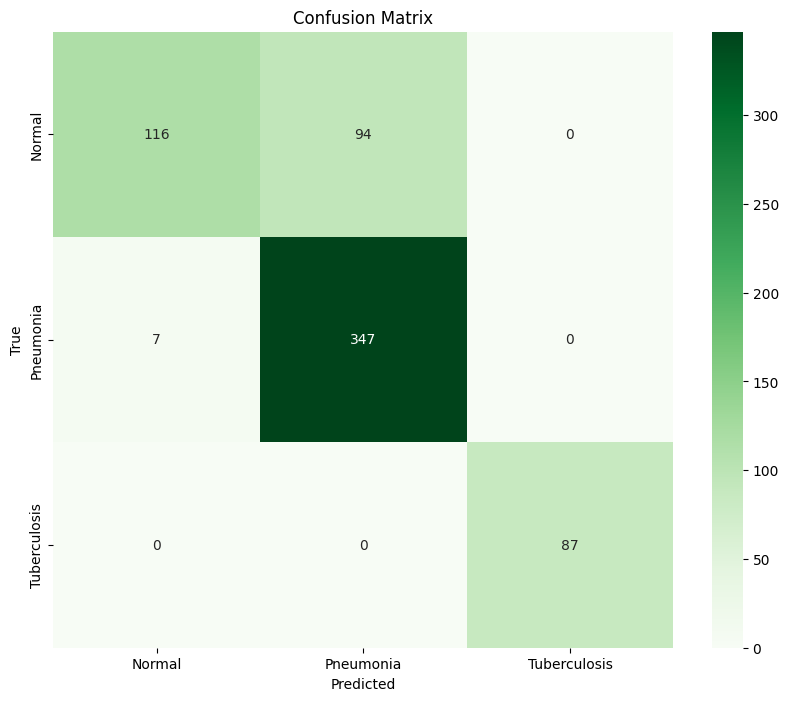

In [34]:
model = load_model('model8485.h5')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(labels_test_numeric, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels= classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [36]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(labels_test_numeric, y_pred_classes))

21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
              precision    recall  f1-score   support

           0       0.94      0.55      0.70       210
           1       0.79      0.98      0.87       354
           2       1.00      1.00      1.00        87

    accuracy                           0.84       651
   macro avg       0.91      0.84      0.86       651
weighted avg       0.87      0.84      0.83       651



In [ ]:
model.save('model8485.h5')

In [ ]:
#SKEMA 3
base_model = DenseNet121(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         )

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_oversampled, labels_oversampled, epochs=5, batch_size=32, validation_data=(X_val, labels_val_numeric))

Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.8031 - loss: 0.4933 - val_accuracy: 0.9403 - val_loss: 0.1687
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.9205 - loss: 0.2017 - val_accuracy: 0.9509 - val_loss: 0.1283
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.9264 - loss: 0.1913 - val_accuracy: 0.9605 - val_loss: 0.1079
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.9261 - loss: 0.1861 - val_accuracy: 0.9258 - val_loss: 0.1755
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.9337 - loss: 0.1627 - val_accuracy: 0.8882 - val_loss: 0.2387


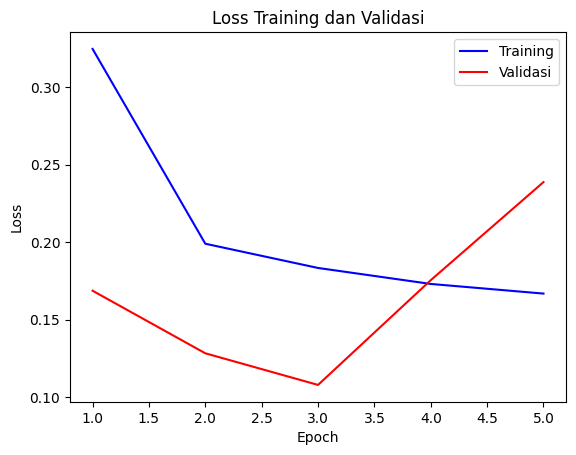

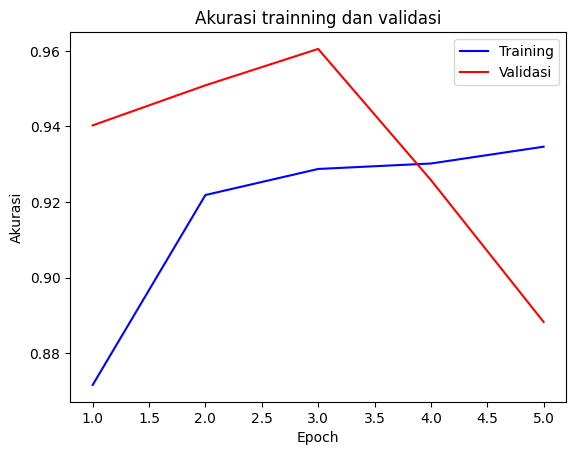

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Validasi')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_accuracy, 'b', label='Training')
plt.plot(epochs, val_accuracy, 'r', label='Validasi')
plt.title('Akurasi trainning dan validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

In [20]:
loss, accuracy = model.evaluate(X_test, labels_test_numeric)
print("Akurasi : ", accuracy * 100)

21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 970ms/step - accuracy: 0.9095 - loss: 0.2165
Akurasi :  88.01843523979187


21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


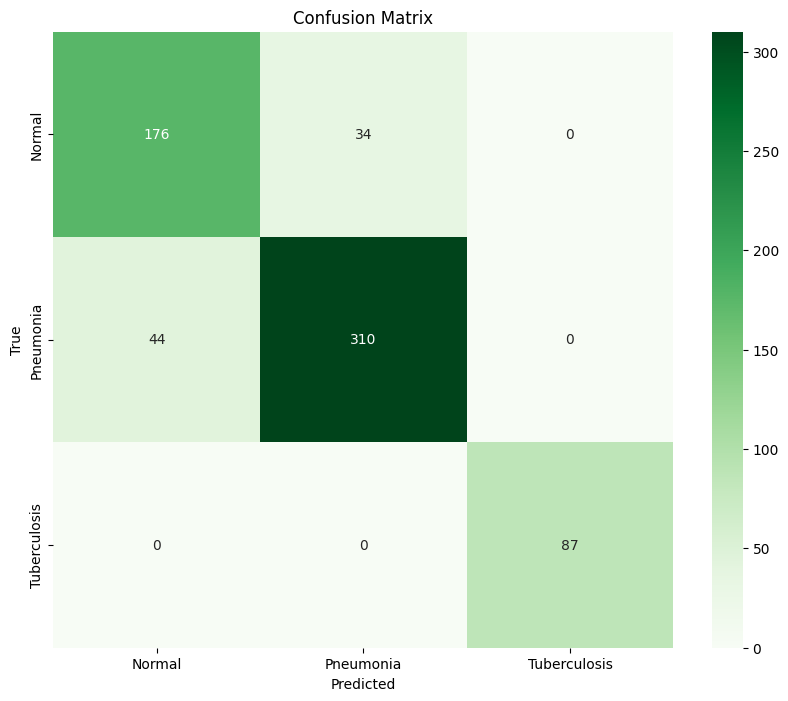

In [19]:
from tensorflow.keras.models import load_model
model = load_model('model88.h5')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(labels_test_numeric, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels= classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(labels_test_numeric, y_pred_classes))

21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       210
           1       0.90      0.88      0.89       354
           2       1.00      1.00      1.00        87

    accuracy                           0.88       651
   macro avg       0.90      0.90      0.90       651
weighted avg       0.88      0.88      0.88       651



In [ ]:
model.save('model88.h5')